In [1]:
#install package
!pip install SwarmPackagePy

  Preparing metadata (setup.py) ... done
  Created wheel for SwarmPackagePy: filename=SwarmPackagePy-1.0.0a5-py3-none-any.whl size=21160 sha256=cbf1ae10f72eabe7f8515cd80c226f890a3f9d0be8471ffde6d67ed4f590d508
  Stored in directory: /root/.cache/pip/wheels/7b/a1/da/a4705dd3dc62b3e4e4b614c96f399d3a0ffa3cb04105813527
Successfully built SwarmPackagePy


In [4]:
from math import sqrt
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
import joblib  # Use joblib for saving LabelEncoder objects

#Load data
path = '/content/drive/MyDrive/dataset/raw data.csv'
data = pd.read_csv(path)

# Columns to encode
columns_to_encode = ['Feed', 'Cell type', 'Anode', 'Cathode', 'Electrolyte']

# Dictionary to store LabelEncoders
label_encoders = {}

# Function to encode and inverse transform
def encode_column(column_values):
    le = LabelEncoder()
    encoded_values = le.fit_transform(column_values)
    label_encoders[column_values.name] = le
    return encoded_values

def inverse_transform_column(column_name, encoded_values):
    le = label_encoders.get(column_name)
    if le is not None:
        return le.inverse_transform(encoded_values)
    else:
        raise ValueError(f"No LabelEncoder found for column {column_name}")

# Apply encoding
for column in columns_to_encode:
    data[column] = encode_column(data[column])

# Specify the folder to save LabelEncoders
save_folder = 'content/label_encoders'

# Create the folder if it doesn't exist
os.makedirs(save_folder, exist_ok=True)

# Save LabelEncoders to files using joblib in the specified folder
for column, le in label_encoders.items():
    filename = os.path.join(save_folder, f"{column}_label_encoder.pkl")
    joblib.dump(le, filename)
    print(f"LabelEncoder for {column} saved as {filename}")

#----
print('')
print('Data Input Information before imputing')
print(data.head())
print(f'Original shape {data.shape}')

X = data.drop(['CR (%)', 'ECR PY (%)', 'PDOs PY (%)', 'POHs PY (%)', 'V'], axis=1)
X = np.array(X) # convert to numpy array

y = data['CR (%)'] #output feature
y = np.asarray(y).reshape(-1, 1) #reshaping to avoid become series data

print('')
print(f'Current shape for input (X): {X.shape} and for output (y): {y.shape}')

#-----
#imputation for missing value using kNN algo
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=10) #create an instance of KNNImputer class, k is desired number of neighbours

#perform imputation on on X because y no missing values
X = imputer.fit_transform(X)

print(f'Imputer result shape {X.shape}')
#------

#Preprocessing by using standar scaler
from sklearn.preprocessing import StandardScaler #standardscaler for normalization (Jinesh et al., 2023)
Xscaler = StandardScaler()
Xscaler.fit(X) #normalizing X
X = Xscaler.transform(X)

Yscaler = StandardScaler()
Yscaler.fit(y) #normalizing y
y = Yscaler.transform(y)


LabelEncoder for Feed saved as content/label_encoders/Feed_label_encoder.pkl
LabelEncoder for Cell type saved as content/label_encoders/Cell type_label_encoder.pkl
LabelEncoder for Anode saved as content/label_encoders/Anode_label_encoder.pkl
LabelEncoder for Cathode saved as content/label_encoders/Cathode_label_encoder.pkl
LabelEncoder for Electrolyte saved as content/label_encoders/Electrolyte_label_encoder.pkl

Data Input Information before imputing
   Feed   Mi  Cell type  Stir rate  Anode  Cathode  Anode surface area  \
0     1  0.5          1        400      0        3               66.49   
1     1  0.3          1        650      0        3              121.38   
2     1  0.3          1        650      0        3              121.38   
3     1  0.3          1        650      0        3              121.38   
4     1  0.3          1        650      0        3              121.38   

   Cathode surface area     T     J   V       I  pH  Electrolyte  t  CR (%)  \
0                12

In [5]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.3, random_state = 42)
print('Training X Shape:', train_X.shape)
print('Training y Shape:', train_y.shape)
print('Testing X Shape:', test_X.shape)
print('Testing y Shape:', test_y.shape)

Training X Shape: (312, 14)
Training y Shape: (312, 1)
Testing X Shape: (134, 14)
Testing y Shape: (134, 1)


In [30]:
import numpy as np

# Define the criteria for each variable
criteria = {
    'Feed':[0, 1],
    'Mi': [0.25, 4.35],
    'Cell type':[1, 1], # 0 - DC, 1 - SC
    'Stir rate': [0, 650],
    'Anode' : [0, 0], # 0 - pt, 1 - tiruo2
    'Cathode' : [0, 0], # 0-CBAC, 1-CBD, 2-Pb, 3-Pt, 4-SS, 5-TiRuO2, 6-Zn
    'Anode surface area': [0.071, 0.071], #Pt - 4.34 (11, 121.38) discacting pt - 0.071
    'Cathode surface area': [7.85, 7.85], #C - 11 (11, 124.34), 0.17 - small Pt
    'T': [25, 80],
    'J': [1, 10], #0.003, 0.006
    #'V': [0, 24],
    'I': [1, 4], #0.01, 0.02
    'pH': [1, 3], #1, 11
    'Electrolyte': [0, 1], # 0-H2SO4,1-HCl,2-KCl,3-,4-,5-,6-,7-
    't': [0, 24]
}

# Create vectors for LB and UB
variables = list(criteria.keys())
LB = np.zeros(len(variables))
UB = np.ones(len(variables))

# Apply the criteria to set LB and UB values
for i, (variable, bounds) in enumerate(criteria.items()):
    LB[i] = bounds[0]
    UB[i] = bounds[1]

# Display the resulting vectors
# print("Variables:", variables)
np.set_printoptions(suppress=True)
print("LB:", LB)
print("UB:", UB)

print(LB.shape, UB.shape)

LB = list(LB)
UB = list(UB)

LB: [ 0.     0.25   1.     0.     0.     0.     0.071  7.85  25.     1.
  1.     1.     0.     0.   ]
UB: [  1.      4.35    1.    650.      0.      0.      0.071   7.85   80.
  10.      4.      3.      1.     24.   ]
(14,) (14,)


In [31]:
#Fitting model
from xgboost import XGBRegressor
modelpso = XGBRegressor(learning_rate=0.05, max_depth=5, min_child_weight=4, n_estimators=5000, reg_alpha=0, gamma=0, reg_lambda=0) #was optimized using gridsearch
modelpso.fit(train_X, train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=5000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [32]:
#Test with data test
from sklearn.metrics import r2_score
print(r2_score(test_y, modelpso.predict(test_X)))

0.9760817196390749


In [33]:
def find_optimal_cr(input_val):

    #Thresholding for categorial, it is start from column 11 to end
    input_opt = [round(x) if i in [0, 2, 4, 5, 12] else float(x) for i, x in enumerate(input_val)]
    input_opt = np.asarray(input_opt)

    input_opt = input_opt.reshape(1,-1)
    input_opt = Xscaler.transform(input_opt)

    #xgboost regression
    predictions = modelpso.predict(input_opt) #predicted, expected = test_y

    logger.append([input_opt[0],-predictions[0]])
    loggerRealValue.append([Xscaler.inverse_transform(input_opt)[0],Yscaler.inverse_transform(predictions[0].reshape(-1,1,))[0][0]])

    #PSO find the lowest value as optimum score, so multiple it with minus
    return -predictions

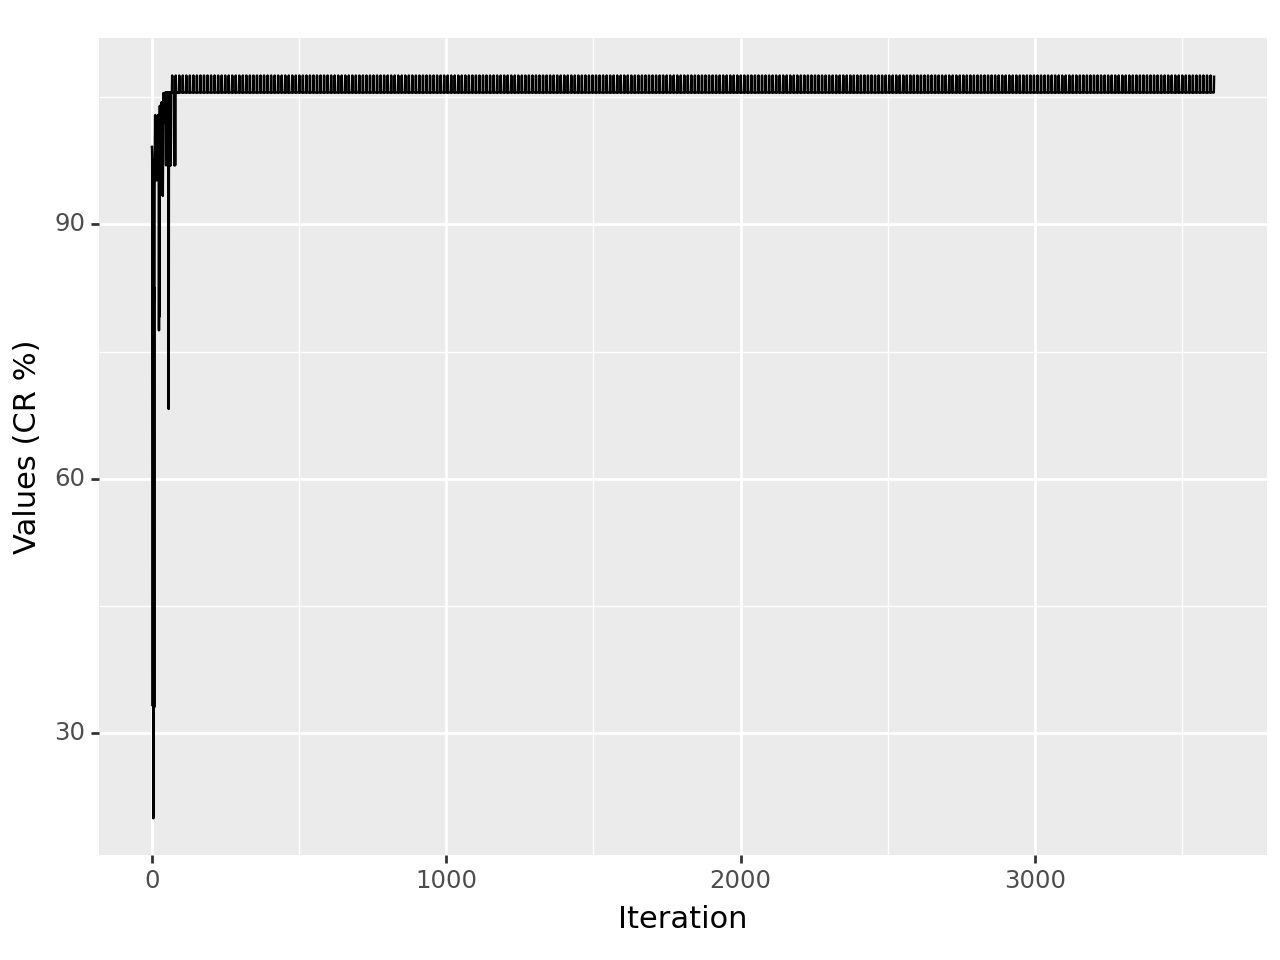


Real best value: [1, 1.3705660756836426, 1, 589.657957001054, 0, 0, 0.071, 7.85, 86.51339870507462, 0.32959108327418485, 0.9448930200721264, 2.808895363370199, 1, 25.967005814038732]

Encode best input to real value
{'Feed': 'Glycerol', 'Mi': 1.3705660756836426, 'Cell type': 'Single cell', 'Stir rate': 589.657957001054, 'Anode': 'Pt', 'Cathode': 'CBAC', 'Anode surface area': 0.071, 'Cathode surface area': 7.85, 'T': 86.51339870507462, 'J': 0.32959108327418485, 'I': 0.9448930200721264, 'pH': 2.808895363370199, 'Electrolyte': 'HCl', 't': 25.967005814038732, 'CR (%)': 107.564545}


In [35]:
#PSO
import SwarmPackagePy

#nName
method = 'PSO'

logger = []
loggerRealValue = []

#SwarmPackagePy.pso(n or agents, function, lb, ub, dimension, iteration)
alh = SwarmPackagePy.pso(10, find_optimal_cr, LB, UB, 14, 300, w=0.5, c1=1, c2=1)

#Save real value before inverse transform from scaller from PSO process, col 0 is input following labels, col 1 is output
pd.DataFrame(logger).to_csv(f'result_optim{method}.csv', index = False)

#Save real value after inverse transform from scaller from PSO process, col 0 is input following labels, col 1 is output
pd.DataFrame(loggerRealValue).to_csv(f'result_optimReal{method}.csv', index = False)

#Plot
from plotnine import ggplot, aes, geom_line
import pandas as pd

# Read data from CSV file excluding the first column
data = pd.read_csv(f'result_optimReal{method}.csv').iloc[:, 1:]

df = pd.DataFrame({'Values (CR %)': data.values.flatten()})
df['Iteration'] = df.index

p = ggplot(df, aes(x='Iteration', y='Values (CR %)'))
p += geom_line()

# Display the plot
print(p)

#Find Best
labels = [
   'Feed',
    'Mi',
    'Cell type',
    'Stir rate',
    'Anode',
    'Cathode',
    'Anode surface area',
    'Cathode surface area',
    'T',
    'J',
    #'V',
    'I',
    'pH',
    'Electrolyte',
    't'
]

output_variable = 'CR (%)'

predicted_output = find_optimal_cr(alh.get_Gbest())
predicted_output = Yscaler.inverse_transform(-predicted_output.reshape(-1,1))

# Create a dictionary to associate labels with values
summary_dict = {label: value for label, value in zip(labels, alh.get_Gbest())}
summary_dict[output_variable] = predicted_output[0][0]

print(f'Real best value: {[round(x) if i in [0, 2, 4, 5, 12] else float(x) for i, x in enumerate(alh.get_Gbest())]}')

#Inverse Encoding
columns_to_encode = ['Feed', 'Cell type', 'Anode', 'Cathode', 'Electrolyte']

for column in columns_to_encode:
    summary_dict[column] = inverse_transform_column(column, np.array([round(summary_dict[column])]))[0]

print('')
print('Encode best input to real value')
print(summary_dict)

df = pd.DataFrame([summary_dict])
df.to_csv(f'best{method}.csv', index=False)


In [ ]:
import pandas as pd
import numpy as np

data_dict = {
    'Feed': 1, 'Mi': 0.91, 'Cell type': 1, 'Stir rate': 692.91,
    'Anode': 0, 'Cathode': 1, 'Anode surface area': 0.071, 'Cathode surface area': 0.17,
    'T': 39.94, 'J': 0.003, 'I': 0.016, 'pH': 2.00,
    'Electrolyte': 0, 't': 9.37, 'CR (%)': 72.56
}

points = 1000

# Set boundaries for plot to t and pH
t_values = np.linspace(0, 24, points)
pH_values = np.linspace(1, 5, points)

# Repeat the dictionary to create the DataFrame
data_list = [data_dict] * points
df = pd.DataFrame(data_list)

# Add 't' and 'pH' columns to the DataFrame
df['t'] = t_values
df['pH'] = pH_values

# Split DataFrame into dfy (containing 'CR%' column) and dfx (containing other columns)
dfy = df['CR (%)']
dfx = df.drop('CR (%)', axis=1)

X = Xscaler.transform(dfx)

print(dfx.shape, dfy.shape)

(1000, 14) (1000,)


In [ ]:
import pandas as pd
import numpy as np

logger = []

def find_optimal_cr(input_val):
    data_dict = {
    'Feed': 1, 'Mi': 0.91, 'Cell type': 1, 'Stir rate': 692.91,
    'Anode': 0, 'Cathode': 1, 'Anode surface area': 0.071, 'Cathode surface area': 0.17,
    'T': 39.94, 'J': 0.003, 'I': 0.016, 'pH': 2.55,
    'Electrolyte': 0, 't': 9.37, 'CR (%)': 72.56
    }

    df = pd.DataFrame([data_dict])

    # Add 't' and 'pH' columns to the DataFrame
    df['t'] = input_val[0]
    df['pH'] = input_val[1]

    # Split DataFrame into dfy (containing 'CR%' column) and dfx (containing other columns)
    dfy = df['CR (%)']
    dfx = df.drop('CR (%)', axis=1)

    #Transform
    X = Xscaler.transform(dfx)

    # Predictions on test data
    y = modelpso.predict(X)

    # Inverse transform y
    y = Yscaler.inverse_transform(y.reshape(-1, 1))

    logger.append([input_val[0], input_val[1], y[0][0]])

    return -y

In [ ]:
#PSO
import SwarmPackagePy

#nName
method = 'PSO'
loggerRealValue = []

LB = [0, 1]
UB = [24, 5]

LB = list(LB)
UB = list(UB)

#SwarmPackagePy.pso(n or agents, function, lb, ub, dimension, iteration)
alh = SwarmPackagePy.pso(200, find_optimal_cr, LB, UB, 2, 100,  w=0.5, c1=1, c2=1)

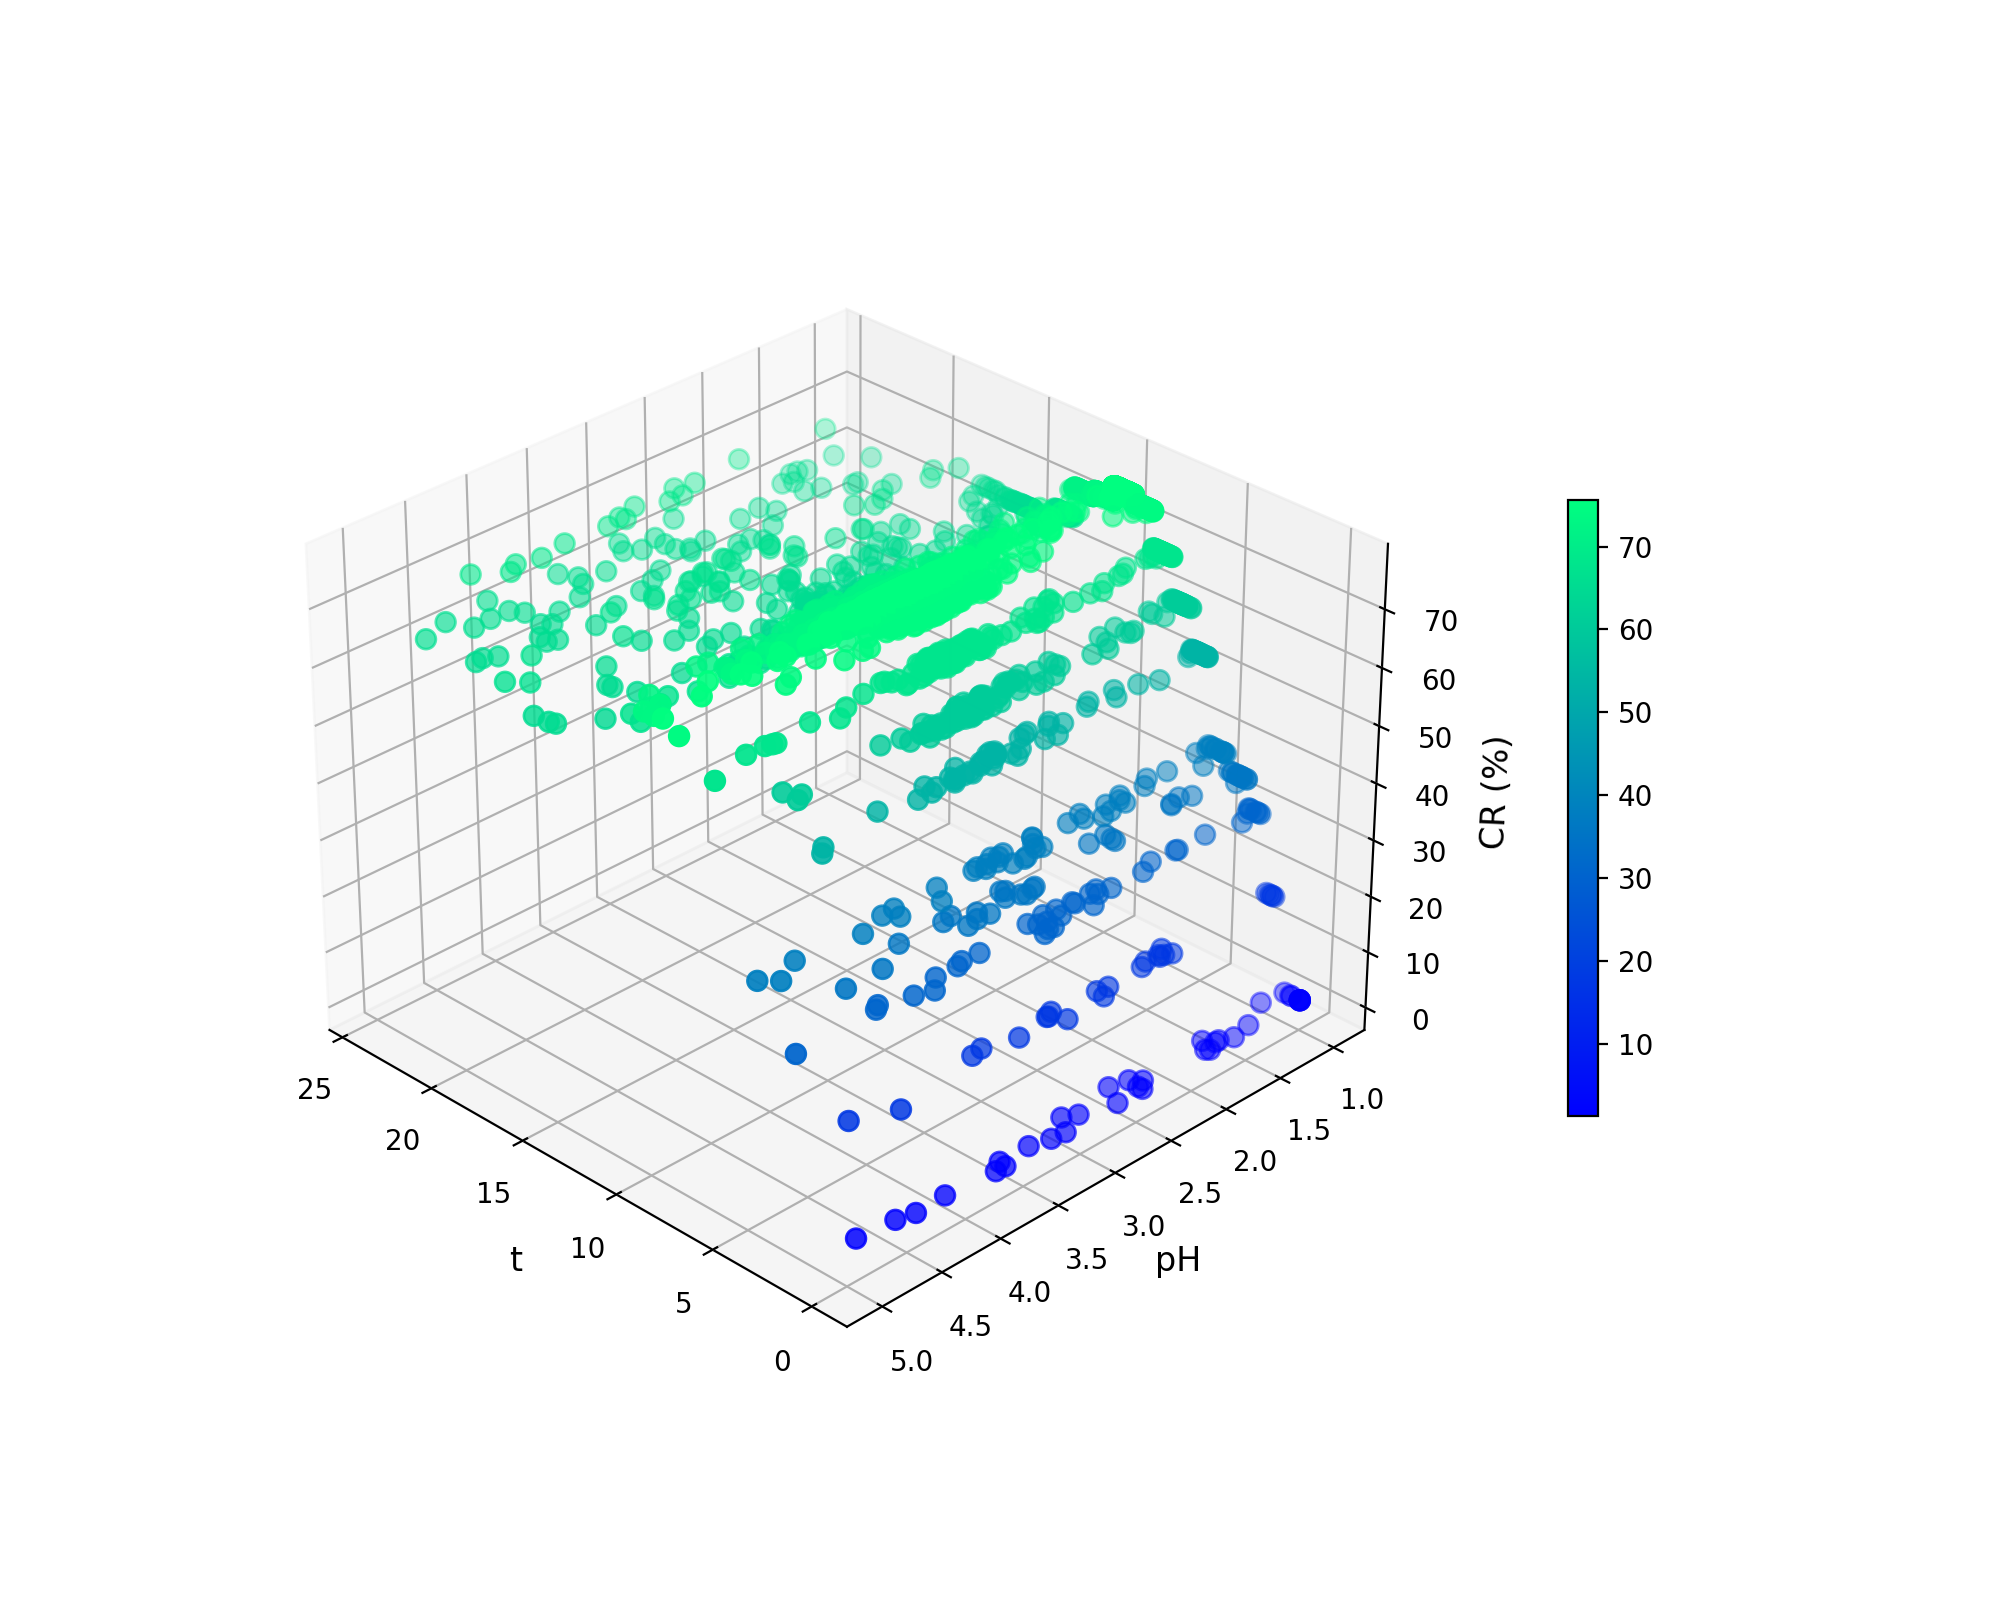

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import Normalize

# Extracting X, Y, Z data
X = [entry[0] for entry in logger]
Y = [entry[1] for entry in logger]
Z = [entry[2] for entry in logger]

# Create a colormap
cmap = plt.cm.get_cmap('winter')

# Normalize the Z-values to map them to colors
norm = Normalize(vmin=min(Z), vmax=max(Z))

# Create 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot data points with colors based on Z-values
sc = ax.scatter(X, Y, Z, c=Z, cmap=cmap, marker='o', s=50, norm=norm)

# Set labels with font
ax.set_xlabel('t', fontsize=12, fontname='Arial')
ax.set_ylabel('pH', fontsize=12, fontname='Arial')
ax.set_zlabel('CR (%)', fontsize=12, fontname='Arial')

# Set rotation angles
ax.view_init(elev=30, azim=135)

# Add color bar with font
cbar = fig.colorbar(sc, ax=ax, pad=0.1, shrink=0.5)
#cbar.set_label('CR (%)', fontsize=12, fontname='Arial')

# Set font globally
plt.rcParams['font.family'] = 'Arial'

# Show plot
plt.show()

In [ ]:
#GWO
import SwarmPackagePy

#nName
method = 'GWO'

logger = []
loggerRealValue = []

#SwarmPackagePy.pso(n or agents, function, lb, ub, dimension, iteration)
alh = SwarmPackagePy.gwo(12, find_optimal_cr, LB, UB, 14, 200)

#Save real value before inverse transform from scaller from PSO process, col 0 is input following labels, col 1 is output
pd.DataFrame(logger).to_csv(f'result_optim{method}.csv', index = False)

#Save real value after inverse transform from scaller from PSO process, col 0 is input following labels, col 1 is output
pd.DataFrame(loggerRealValue).to_csv(f'result_optimReal{method}.csv', index = False)

#Plot
from plotnine import ggplot, aes, geom_line
import pandas as pd

# Read data from CSV file excluding the first column
data = pd.read_csv(f'result_optimReal{method}.csv').iloc[:, 1:]

df = pd.DataFrame({'Values (CR %)': data.values.flatten()})
df['Iteration'] = df.index

p = ggplot(df, aes(x='Iteration', y='Values (CR %)'))
p += geom_line()

# Display the plot
print(p)

#Find Best
labels = [
    'Feed',
    'Mi',
    'Cell type',
    'Stir rate',
    'Anode',
    'Cathode',
    'Anode surface area',
    'Cathode surface area',
    'T',
    'J',
    #'V',
    'I',
    'pH',
    'Electrolyte',
    'T'
]

output_variable = 'CR (%)'

predicted_output = find_optimal_cr(alh.get_Gbest())
predicted_output = Yscaler.inverse_transform(-predicted_output.reshape(-1,1))

# Create a dictionary to associate labels with values
summary_dict = {label: value for label, value in zip(labels, alh.get_Gbest())}
summary_dict[output_variable] = predicted_output[0][0]

print(f'Real best value: {[round(x) if i in [0, 2, 4, 5, 12] else float(x) for i, x in enumerate(alh.get_Gbest())]}')

#Inverse Encoding
columns_to_encode = ['Feed', 'Cell type', 'Anode', 'Cathode', 'Electrolyte']

for column in columns_to_encode:
    summary_dict[column] = inverse_transform_column(column, np.array([round(summary_dict[column])]))[0]

print('')
print('Encode best input to real value')
print(summary_dict)

df = pd.DataFrame([summary_dict])
df.to_csv(f'best{method}.csv', index=False)

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (12, 14) and arg 1 with shape (2,).